In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import mediapipe as mp

# Keypoints using MP Holistic

In [2]:
# Initialize Mediapipe Holistic model
mp_drawing = mp.solutions.drawing_utils
mp_holistic = mp.solutions.holistic

In [3]:
def mediapipe_detection(image, model):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = model.process(image_rgb)
    image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)
    return image_bgr, results

In [4]:
def draw_landmarks(image, results):
    # Colors for drawing
    color_face = mp_drawing.DrawingSpec(color=(80, 110, 10), thickness=1, circle_radius=1)
    color_face_connection = mp_drawing.DrawingSpec(color=(80, 256, 121), thickness=1, circle_radius=1)
    color_hand = mp_drawing.DrawingSpec(color=(121, 22, 76), thickness=2, circle_radius=4)
    color_pose = mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2)

    # Draw the landmarks
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                                      color_face, color_face_connection)
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, color_hand)
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, color_hand)
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS, color_pose)

In [5]:
def capture_video():
    cap = cv2.VideoCapture(0)
    results_list = []

    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        while cap.isOpened():
            success, image = cap.read()
            if not success:
                break

            # Pass the frames through the model
            image_bgr, results = mediapipe_detection(image, holistic)

            # Draw landmarks on the frames
            draw_landmarks(image_bgr, results)

            # Store the results
            results_list.append(results)

            # Display the image
            cv2.imshow('Real-Time Object Detection with Landmarks', image_bgr)

            # Check for 'q' key press to exit
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break

    cap.release()
    cv2.destroyAllWindows()
    return image_bgr, results_list


In [31]:
image, results_list = capture_video()

c:\Users\samer\anaconda3\envs\samerenv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


In [28]:
# Draw landmarks on the last frame
draw_landmarks(image, results_list[-1])

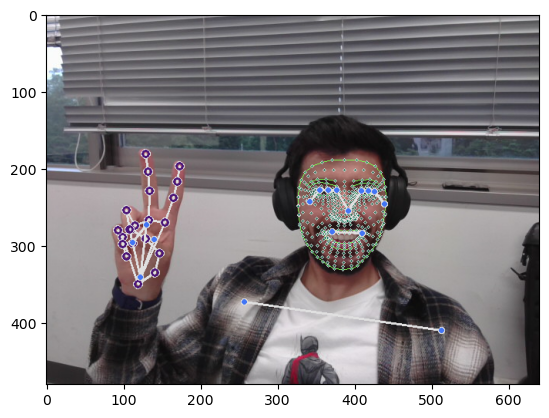

In [29]:
# Visualize the last frame with its landmarks
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Extract the Keypoint Values

* Here we need to extract all the keypoints and convert them to numpy arrays.

In [5]:
def extract_keypoints(results):
    # Define the landmarks for extraction
    pose = results.pose_landmarks.landmark if results.pose_landmarks else []
    face = results.face_landmarks.landmark if results.face_landmarks else []
    left_hand = results.left_hand_landmarks.landmark if results.left_hand_landmarks else []
    right_hand = results.right_hand_landmarks.landmark if results.right_hand_landmarks else []

    pose_row = np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in pose]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face_row = np.array([[landmark.x, landmark.y, landmark.z] for landmark in face]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh_row = np.array([[landmark.x, landmark.y, landmark.z] for landmark in left_hand]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh_row = np.array([[landmark.x, landmark.y, landmark.z] for landmark in right_hand]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose_row, face_row, lh_row, rh_row])

# Setup Folders for Data Collection

In [7]:
# Setup the path for exporting data
data_path = os.path.join('MP_Data')

# Actions that we want to recognize
actions = np.array(['hello', 'more', 'ok'])
num_sequences = 30 # number of videos to take for one action
sequence_length = 60 # number of frames per sequence

In [8]:
# Create the directories for each action and sequence
for action in actions:
    for sequence in range(num_sequences):
        os.makedirs(os.path.join(data_path, action, str(sequence)), exist_ok=True)

# Collect the Dataset

In [9]:
def collect_dataset(action: str):
    cap = cv2.VideoCapture(0)
    
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        # Loop through the sequences
        for sequence in range(num_sequences):
            for frame_num in range(sequence_length):
                success, frame = cap.read()
                if not success:
                    break

                # Pass the frames through the model
                image_bgr, results = mediapipe_detection(frame, holistic)

                # Draw landmarks on the frames
                draw_landmarks(image_bgr, results)

                # Apply a logic for taking pauses between recorded sequences
                if frame_num == 0:
                    cv2.putText(image_bgr, 'Starting Collection', (120, 200),
                                cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image_bgr, f'Collecting frames for {action}, Video {sequence}', (15, 12),
                                cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.waitKey(2000)
                else:
                    cv2.putText(image_bgr, f'Collecting frames for {action}, Video {sequence}', (15, 12),
                                cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Display the image
                    cv2.imshow('Data Collection Window', image_bgr)

                keypoints = extract_keypoints(results)
                npy_path = os.path.join(data_path, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)


                # Check for 'q' key press to exit
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

    cap.release()
    cv2.destroyAllWindows()


In [12]:
collect_dataset('ok')

# Preprocess the Data and Create Labels and Features

In [6]:
data_path = 'MP_Data'
actions = ['hello', 'more', 'ok']
num_sequences = 30
sequence_length = 30

# Prepare the data and iterate over actions
def load_data(data_path, actions, num_sequences, sequence_length):
  X, y = [], []

  for action in actions:
    for sequence in range(num_sequences):
      sequence_data = []
      for frame_num in range (sequence_length):
        npy_path = os.path.join(data_path, action, str(sequence), f"{frame_num}.npy")
        res = np.load(npy_path)
        sequence_data.append(res)
      X.append(sequence_data)
      y.append(actions.index(action))

  return np.array(X), np.array(y)

X, y = load_data(data_path, actions, num_sequences, sequence_length)

In [7]:
X.shape, y.shape

((90, 30, 1662), (90,))

In [8]:
from sklearn.model_selection import train_test_split

# Initial split: train and temporary test set
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

# Further split the train set into train and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.05, random_state=42)

# Shapes of the resulting splits
print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}, Test shape: {X_test.shape}")
print(f"Train labels shape: {y_train.shape}, Validation labels shape: {y_val.shape}, Test labels shape: {y_test.shape}")

Train shape: (80, 30, 1662), Validation shape: (5, 30, 1662), Test shape: (5, 30, 1662)
Train labels shape: (80,), Validation labels shape: (5,), Test labels shape: (5,)


In [9]:
def augment_data(sequence):
    # Apply milder random noise
    noise = np.random.normal(0, 0.005, sequence.shape)
    sequence += noise
    
    # Apply milder random scaling
    scale = np.random.uniform(0.98, 1.02)
    sequence *= scale
    
    return sequence

In [11]:
import torch
from torch.utils.data import Dataset, DataLoader

# Define custom dataset class
class AugmentedDataset(Dataset):
    def __init__(self, X, y, augment=True):
        self.X = X
        self.y = y
        self.augment = augment

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        sample_X = self.X[idx]
        sample_y = self.y[idx]

        if self.augment:
            sample_X = augment_data(sample_X)

        return torch.tensor(sample_X, dtype=torch.float32), torch.tensor(sample_y, dtype=torch.long)

# Assuming X_train, X_val, X_test, y_train, y_val, y_test are numpy arrays
# Convert them to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create datasets
train_dataset = AugmentedDataset(X_train_tensor, y_train_tensor, augment=True)
val_dataset = AugmentedDataset(X_val_tensor, y_val_tensor, augment=False)
test_dataset = AugmentedDataset(X_test_tensor, y_test_tensor, augment=False)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

In [12]:
# Verify shapes
for inputs, labels in train_loader:
    print(f"Train loader inputs shape: {inputs.shape}, labels shape: {labels.shape}")
    break

for inputs, labels in val_loader:
    print(f"Validation loader inputs shape: {inputs.shape}, labels shape: {labels.shape}")
    break

for inputs, labels in test_loader:
    print(f"Test loader inputs shape: {inputs.shape}, labels shape: {labels.shape}")
    break

Train loader inputs shape: torch.Size([2, 30, 1662]), labels shape: torch.Size([2])
Validation loader inputs shape: torch.Size([2, 30, 1662]), labels shape: torch.Size([2])
Test loader inputs shape: torch.Size([2, 30, 1662]), labels shape: torch.Size([2])


C:\Users\samer\AppData\Local\Temp\ipykernel_51040\169053283.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sample_X, dtype=torch.float32), torch.tensor(sample_y, dtype=torch.long)


In [67]:
import torch.nn as nn
import lightning as pl
from torch.nn import functional as F

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # x: (batch_size, seq_length, num_features)
        h0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        c0 = torch.zeros(num_layers, x.size(0), hidden_size).to(x.device)
        self.lstm.flatten_parameters()
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]  # Take the last output
        out = self.fc(out)
        return out


# Define model parameters
input_size = 1662  # Number of features
hidden_size = 100  # Number of features in hidden state
num_layers = 2  # Number of stacked LSTM layers
num_classes = 3  # Number of output classes

model = LSTMModel(input_size, hidden_size, num_layers, num_classes)

In [68]:
class ActionRecognitionModel(pl.LightningModule):
    def __init__(self, model, num_classes):
        super(ActionRecognitionModel, self).__init__()
        self.model = model
        #self.num_classes = num_classes
        self.criterion = nn.CrossEntropyLoss()
        self.learning_rate = 0.0001  # Initialize with a default learning rate

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        acc = (outputs.argmax(dim=1) == labels).float().mean()
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        acc = (outputs.argmax(dim=1) == labels).float().mean()
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        acc = (outputs.argmax(dim=1) == labels).float().mean()
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

# Train the model

In [69]:
# Initialize and train the model
action_model = ActionRecognitionModel(model, num_classes=num_classes)

In [70]:
from lightning import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.tuner import Tuner

# Define model checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='val_acc',
    dirpath='checkpoints/',
    filename='best-checkpoint_lstm',
    save_top_k=1,
    mode='max'
)

# Define early stopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_acc',
    patience=20,
    mode='max',
    verbose=True
)

# Instantiate the trainer
trainer = Trainer(
    max_epochs=140,
    callbacks=[checkpoint_callback, early_stopping_callback],
    profiler='simple'
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


* Checking the best batch size and learning rate using `Tuner`

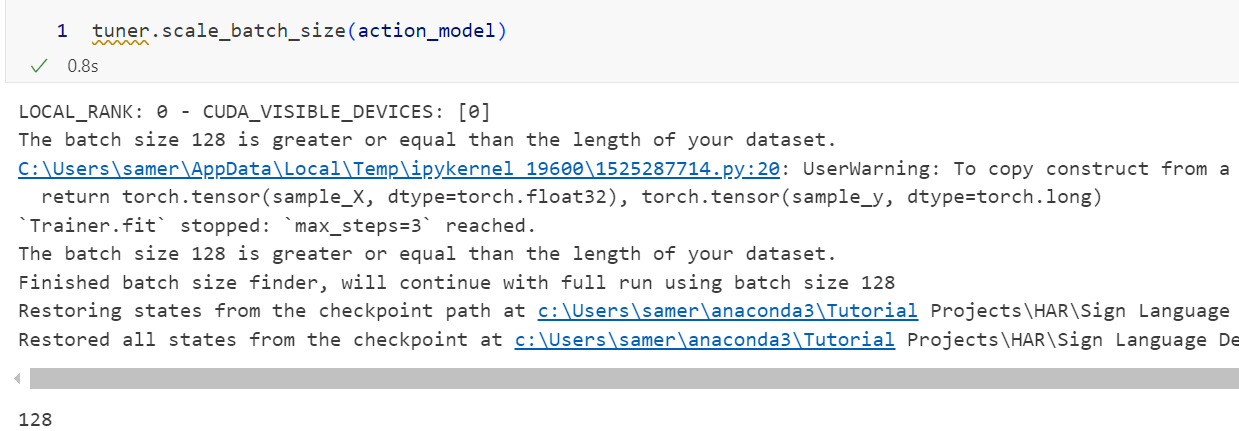

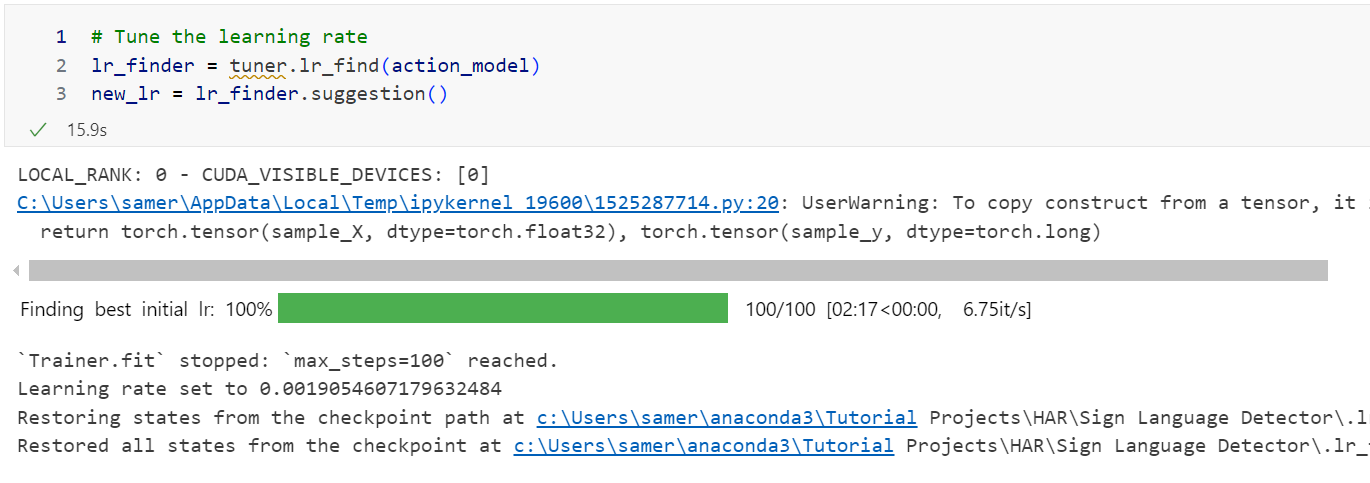

In [71]:
# Train the model
trainer.fit(action_model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | LSTMModel        | 786 K 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
786 K     Trainable params
0         Non-trainable params
786 K     Total params
3.147     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\samer\AppData\Local\Temp\ipykernel_19600\1525287714.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sample_X, dtype=torch.float32), torch.tensor(sample_y, dtype=torch.long)


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_acc improved. New best score: 0.600


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_acc improved by 0.200 >= min_delta = 0.0. New best score: 0.800


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_acc did not improve in the last 20 records. Best score: 0.800. Signaling Trainer to stop.
FIT Profiler Report

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                              	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                            

In [72]:
# Evaluate the model on the test set
trainer.test(action_model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

C:\Users\samer\AppData\Local\Temp\ipykernel_19600\1525287714.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sample_X, dtype=torch.float32), torch.tensor(sample_y, dtype=torch.long)
TEST Profiler Report

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                              	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
-------------------------------------------------------------------------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.800000011920929
        test_loss           0.30853646993637085
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.30853646993637085, 'test_acc': 0.800000011920929}]

# Create a Confusion Matrix

In [73]:
# Function to move data to the appropriate device
def generate_predictions(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

In [74]:
# Load the best checkpoint

# Initialize the LSTM model
model = LSTMModel(input_size, hidden_size, num_layers, num_classes)

best_model_path = 'C:\\Users\\samer\\anaconda3\\Tutorial Projects\\HAR\\Sign Language Detector\\checkpoints\\best-checkpoint_lstm-v3.ckpt'
model = ActionRecognitionModel.load_from_checkpoint(best_model_path, model=model, num_classes=num_classes)

# Move the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Generate predictions
true_labels, predicted_labels = generate_predictions(model, test_loader, device)

C:\Users\samer\AppData\Local\Temp\ipykernel_19600\1525287714.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sample_X, dtype=torch.float32), torch.tensor(sample_y, dtype=torch.long)


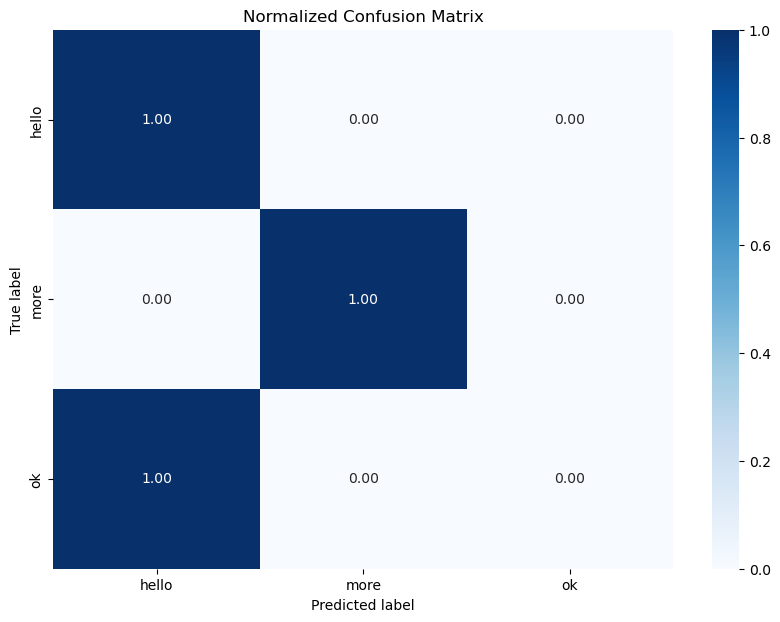

In [75]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Define class names
class_names = ['hello', 'more', 'ok']  # Update this list with your action labels

# Plot the confusion matrix
plot_confusion_matrix(conf_matrix, classes=class_names, normalize=True, title='Normalized Confusion Matrix')

In [76]:
# Define the real-time evaluation function
def evaluate_realtime(model, actions, device):
    cap = cv2.VideoCapture(0)
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Pass the frames through the model
            image_bgr, results = mediapipe_detection(frame, holistic)

            # Draw landmarks on the frames
            draw_landmarks(image_bgr, results)
            
            # Extract keypoints
            keypoints = extract_keypoints(results)
            keypoints = torch.tensor(keypoints, dtype=torch.float32).unsqueeze(0).unsqueeze(1).to(device)
            
            print(f"Keypoints shape: {keypoints.shape}")  # Debug print

            # Make predictions
            model.eval()
            with torch.no_grad():
                outputs = model(keypoints)
                print(f"Model outputs: {outputs}")  # Debug print
                _, predicted = torch.max(outputs, 1)
                action = actions[predicted.item()]

            print(f"Predicted action: {action}")  # Debug print

            # Display predictions
            cv2.putText(image_bgr, f'Action: {action}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
            cv2.imshow('Real-Time Action Recognition', image_bgr)

            if cv2.waitKey(10) & 0xFF == ord('q'):
                break

    cap.release()
    cv2.destroyAllWindows()

In [77]:
# Load the best checkpoint
actions = ['hello', 'more', 'ok']  # Update this list with your action labels
# Evaluate the model in real-time
evaluate_realtime(model, actions, device)

c:\Users\samer\anaconda3\envs\samerenv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Keypoints shape: torch.Size([1, 1, 1662])
Model outputs: tensor([[ 0.1043, -0.1372, -0.0321]], device='cuda:0')
Predicted action: hello
Keypoints shape: torch.Size([1, 1, 1662])
Model outputs: tensor([[ 0.0837, -0.1696, -0.0081]], device='cuda:0')
Predicted action: hello
Keypoints shape: torch.Size([1, 1, 1662])
Model outputs: tensor([[ 0.0912, -0.1528, -0.0197]], device='cuda:0')
Predicted action: hello
Keypoints shape: torch.Size([1, 1, 1662])
Model outputs: tensor([[ 0.0930, -0.1559, -0.0190]], device='cuda:0')
Predicted action: hello
Keypoints shape: torch.Size([1, 1, 1662])
Model outputs: tensor([[ 0.0872, -0.1038, -0.0446]], device='cuda:0')
Predicted action: hello
Keypoints shape: torch.Size([1, 1, 1662])
Model outputs: tensor([[ 0.1536, -0.2249, -0.0198]], device='cuda:0')
Predicted action: hello
Keypoints shape: torch.Size([1, 1, 1662])
Model outputs: tensor([[ 0.1545, -0.2306, -0.0158]], device='cuda:0')
Predicted action: hello
Keypoints shape: torch.Size([1, 1, 1662])
Model 